# Processing data

En general los **datos** que tenemos para entrenar nuestro modelo no son la entrada directa a este y requieren ser transformados en **features** para obtener los mejores resultados.

$$data -> features -> modelo$$

Para lograr esto tenemos algunas opciones:
* hacer las transformaciones previas a entrenar el modelo y generar un dataset con las features
* incorporar estas transformaciones en el modelo construyendo un pipeline

En la primera opción podemos usar [pandas](https://pandas.pydata.org/) para procesar y transformar los datos generando el datset con todas las features y en la segunda opción podemos usar el modulo de [preprocessing de scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html) para aplicar estas transformaciones.

La ventaja de tener las transformaciones como una etapa dentro del modelo es que podemos aplicar transformación particulares a cada uno de nuestros modelos usando siempre el mismo dataset como entrada, mejorar la reproducibilidad y la mantención cuando los modelos están en producción.


La siguiente imagen es un esquema de cómo funcionan los transformer del módulo de preprocessing de scikit-learn
<img src="../images/transformer.png" alt="Scikit-learn Transformer" width=800/>


In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import feature_extraction
from sklearn import preprocessing
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

set_config(display='diagram')   

In [2]:
train_path = '../data/users_train.csv'
train_data = pd.read_csv(train_path)

# Pandas

In [3]:
x_numeric = train_data[['cnt_user_engagement']]

In [4]:
mean = x_numeric.mean()
mean

cnt_user_engagement    30.44548
dtype: float64

In [5]:
var = x_numeric.var()
var

cnt_user_engagement    2642.04759
dtype: float64

In [6]:
x_norm = (x_numeric - mean)/var**0.5
x_norm

,cnt_user_engagement
0,-0.261581
1,-0.495040
2,-0.533950
3,-0.339401
4,-0.436675
...,...
7185,-0.533950
7186,-0.417220
7187,-0.164306
7188,-0.572860


# Scikit-learn
## Transformaciones Numéricas
**Lineales**
* `preprocessing.StandardScaler()`: transforma datos numéricos para que tengan media 0 y desviación estándar 1. $f(x) = \frac{x-\bar x}{\sigma}$
* `preprocessing.MinMaxScaler()`: transforma datos numéricos para que el mínimo valor sea 0 y el máximo sea 1

**No lineales**
* `preprocessing.QuantileTransformer()`: discretiza en quantiles una variable numérica y luego normaliza para obtener una distribución normal


In [7]:
scaler = preprocessing.StandardScaler()

In [8]:
scaler.fit(x_numeric)

,copy,True
,with_mean,True
,with_std,True


In [10]:
x_norm = scaler.transform(x_numeric)
x_norm

array([[-0.26159907],
       [-0.49507447],
       [-0.53398704],
       ...,
       [-0.16431765],
       [-0.5728996 ],
       [ 0.361002  ]])

In [11]:
scaler.mean_, scaler.var_

(array([30.44547983]), array([2641.68012908]))

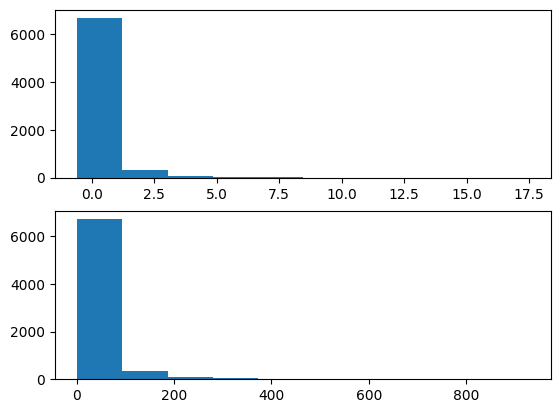

In [12]:
f, ax = plt.subplots(2)
hist = ax[0].hist(x_norm)
hist = ax[1].hist(x_numeric)

>Prueba otras transformacion numerica con los mismos datos y revisa como es la salida de estas transformaciones

## Transformación categóricas 

* `preprocessing.OrdinalEncoder()`: transforma cada una de las categorías en un valor numerico, ej: cl, uy, in -> 0,1,2
* `preprocessing.OneHotEncoder()`: transforma cada una de las categorías en una columna con 0 y 1. ej: cl, uy, in -> [1,0,0], [0,1,0], [0,0,1]

En ambos casos la transformación no aceptan valores nulos por lo que debemos imputar los valores nulos antes de hacer esta.


### OrdinalEncoder

In [16]:
x_categoric = train_data[['country_name']]

In [17]:
ordinal_encoder = preprocessing.OrdinalEncoder()
ordinal_encoder.fit(x_categoric)

,categories,'auto'
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,unknown_value,None
,encoded_missing_value,nan
,min_frequency,None
,max_categories,None


In [18]:
ordinal_encoder.transform(x_categoric)

array([[ 72.],
       [ 48.],
       [ 38.],
       ...,
       [118.],
       [118.],
       [ 56.]])

### One-Hot Encoder

In [21]:
onehot_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
onehot_encoder.fit(x_categoric)

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [22]:
onehot_encoder.transform(x_categoric)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7190 stored elements and shape (7190, 126)>

In [23]:
# si handle_unknown='error' cuando un valor este por fuera del vocabulario va a dar error
# onehot_encoder.transform([['xxxx']])

In [24]:
# si handle_unknown='ignore' cuando un valor este por fuera del vocabulario la salida van a ser solo ceros
# onehot_encoder.transform([['xxxx']])

## Transformaciones en texto
* `feature_extraction.text.CountVectorizer`: es una transformacion similar a one-hot encoding pero con mas flexibilidad para procesar texto

In [77]:
x_vector = x_categoric["country_name"].fillna('')

In [67]:
count_vectorize = feature_extraction.text.CountVectorizer(
    lowercase=True,
    tokenizer=lambda x:x.split(' '),
    token_pattern=None,
    max_features=3,
    binary=True,
)

In [78]:
count_vectorize.fit(x_vector)


,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function <la...t 0x135afda80>
,stop_words,None
,token_pattern,None
,ngram_range,"(1, ...)"
,analyzer,'word'


In [79]:
count_vectorize.transform(x_vector)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 8553 stored elements and shape (7190, 3)>

In [80]:
count_vectorize.transform(x_vector).todense()

matrix([[0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        ...,
        [0, 1, 1],
        [0, 1, 1],
        [0, 0, 0]])

In [81]:
count_vectorize.vocabulary_

{'india': np.int64(0), 'united': np.int64(2), 'states': np.int64(1)}

# Compose
## Pipeline
Scikit-learn nos permite construir un pipeline que no es más que una secuencia de pasos donde se definen transformaciones concatenadas que generan una salida única
<img src="../images/pipeline.png" alt="Scikit-learn Transformer" width=800/>


In [82]:
transformer_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", preprocessing.StandardScaler()),
    ]
)
transformer_numeric

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,0
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [84]:
transformer_categorical = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one-hot", preprocessing.OneHotEncoder(handle_unknown='ignore')),
    ]
)
transformer_categorical

,steps,"[('imputer', ...), ('one-hot', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [85]:
CATEGORICAL_COLUMNS = [
    "country_name",
    "device_os",
    "device_lang",
]
NUMERICAL_COLUMNS = [
    "cnt_user_engagement",
    "cnt_level_start_quickplay",
    "cnt_level_end_quickplay",
    "cnt_level_complete_quickplay",
    "cnt_level_reset_quickplay",
    "cnt_post_score",
    "cnt_spend_virtual_currency",
    "cnt_ad_reward",
    "cnt_challenge_a_friend",
    "cnt_completed_5_levels",
    "cnt_use_extra_steps",
]
IGNORE_COLUMNS = [
    "user_first_engagement",
    "user_pseudo_id",
    "is_enable",
    "bounced",
    "device_lang",
]

In [86]:
transformer_pipeline = ColumnTransformer(
    transformers=[
        ("numeric_features", transformer_numeric, NUMERICAL_COLUMNS),
        ("categorical_features", transformer_categorical, CATEGORICAL_COLUMNS),
        ("ignore_features", "drop", IGNORE_COLUMNS),
    ]
)
transformer_pipeline

,transformers,"[('numeric_features', ...), ('categorical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'constant'
,fill_value,0


In [87]:
transformer_pipeline.fit(train_data)

,transformers,"[('numeric_features', ...), ('categorical_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'constant'
,fill_value,0


In [88]:
transformer_pipeline.transform(train_data).shape

(7190, 287)

In [89]:
model_path = 'models'
if not os.path.exists(model_path):
    os.makedirs(model_path)

joblib.dump(transformer_pipeline, f'{model_path}/transformer_full.joblib')

['models/transformer_full.joblib']

## Pipeline más complejos

In [ ]:
transformer_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", preprocessing.StandardScaler()),
    ]
)
transformer_numeric

In [ ]:
transformer_categorical = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "count_vectorize",
            ColumnTransformer(
                transformers=[
                    (
                        "feature_0",
                        feature_extraction.text.CountVectorizer(
                            lowercase=False,
                            tokenizer=lambda x: x.split("\n"),
                            max_features=3,
                            binary=True,
                        ),
                        0,
                    ),
                    (
                        "feature_1",
                        feature_extraction.text.CountVectorizer(
                            lowercase=False,
                            tokenizer=lambda x: x.split("\n"),
                            max_features=5,
                            binary=True,
                        ),
                        1,
                    ),
                    (
                        "feature_2",
                        feature_extraction.text.CountVectorizer(
                            lowercase=False,
                            tokenizer=lambda x: x.split("\n"),
                            max_features=8,
                            binary=True,
                        ),
                        2,
                    ),
                ]
            ),
        ),
    ]
)
transformer_categorical

In [ ]:
transformer_pipeline = ColumnTransformer(
    transformers=[
        ("numeric_features", transformer_numeric, NUMERICAL_COLUMNS),
        ("categorical_features", transformer_categorical, CATEGORICAL_COLUMNS),
        ("ignore_features", "drop", IGNORE_COLUMNS),
    ]
)
transformer_pipeline

In [ ]:
transformer_pipeline.fit_transform(train_data).shape